# EX_03

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import numpy as np
import math
import torch.optim as optim
import torch.nn as nn

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Physical and Simulation Parameters ---
Nx = Ny = 256  # Grid points
lambda0_scalar = 532e-9  # m, wavelength
Lx_phys = Ly_phys = 0.6e-3  # m, physical size of computational window

# Propagation distances
Lz_segment = 5 * Lx_phys  # Distance P1-P2, and P2-P3
L_total = 2 * Lz_segment


# --- Helper Functions ---
def create_grids(N, phys_L, device_val, dtype_val=torch.float32):
    """Creates 1D and 2D coordinate and frequency grids."""
    dx = phys_L / N
    # Spatial coordinates
    x_1d = torch.linspace(-phys_L / 2, phys_L / 2 - dx, N, device=device_val, dtype=dtype_val)
    X, Y = torch.meshgrid(x_1d, x_1d, indexing='ij')

    # Spatial frequencies (for torch.fft.fft2 output order: DC at [0,0])
    kx_1d = 2 * math.pi * torch.fft.fftfreq(N, d=dx, device=device_val, dtype=dtype_val)
    Ky, Kx = torch.meshgrid(kx_1d, kx_1d, indexing='ij') # Note: meshgrid's first arg varies slowest (rows)
                                                      # For (ky, kx) to match image (row, col) -> (y, x)
                                                      # Ky corresponds to y (rows), Kx to x (cols)
    return X, Y, Kx, Ky, dx


# --- Angular Spectrum Propagator ---
def propagate_angular_spectrum(field_xy_in, Lz_prop, lambda0_s, Lx_s, Ly_s, backward=False):
    """
    Propagates a 2D complex field using the angular spectrum method.
    Assumes field_xy_in is complex.
    For backward propagation, set backward=True.
    """
    N_y, N_x = field_xy_in.shape
    current_device = field_xy_in.device
    dtype_real = torch.float32 # Base for physical params
    dtype_complex = field_xy_in.dtype


    lambda0 = torch.tensor(lambda0_s, device=current_device, dtype=dtype_real)
    k0 = 2 * math.pi / lambda0

    _, _, Kx_grid, Ky_grid, _ = create_grids(N_x, Lx_s, current_device, dtype_val=dtype_real)
    # Ky_grid, Kx_grid from create_grids are for (Ny, Nx) if Ly, Lx used for Ny, Nx respectively
    # If Nx=Ny and Lx=Ly, then Kx_grid and Ky_grid from create_grids(Nx, Lx_s, ...) is fine.

    Kx2_plus_Ky2 = Kx_grid**2 + Ky_grid**2

    # kz component
    # sqrt_arg can be negative for evanescent waves
    sqrt_arg = k0**2 - Kx2_plus_Ky2
    kz = torch.sqrt(torch.complex(torch.relu(sqrt_arg), torch.abs(torch.minimum(sqrt_arg, torch.tensor(0.0, device=current_device)))))
    # For evanescent waves (sqrt_arg < 0): kz becomes purely imaginary: j * sqrt(abs(sqrt_arg))
    # This leads to exp(- Lz * sqrt(Kx2+Ky2-k0^2)), which is decay.

    # Propagator
    if backward:
        propagator_k_space = torch.exp(-1j * kz.to(dtype_complex) * Lz_prop) # H* or H(-Lz)
    else:
        propagator_k_space = torch.exp(1j * kz.to(dtype_complex) * Lz_prop)  # H

    # Perform propagation
    field_k_space = torch.fft.fft2(field_xy_in)
    propagated_k_space = field_k_space * propagator_k_space
    propagated_field_xy = torch.fft.ifft2(propagated_k_space)

    return propagated_field_xy

Using device: cpu


In [21]:
t_mid_A = torch.load("t_mid_A.pt").to(device)
t_mid_B = torch.load("t_mid_B.pt").to(device)
U_out_A = torch.load("U_out_A.pt").to(device)
U_out_B = torch.load("U_out_B.pt").to(device)

## Scenario A

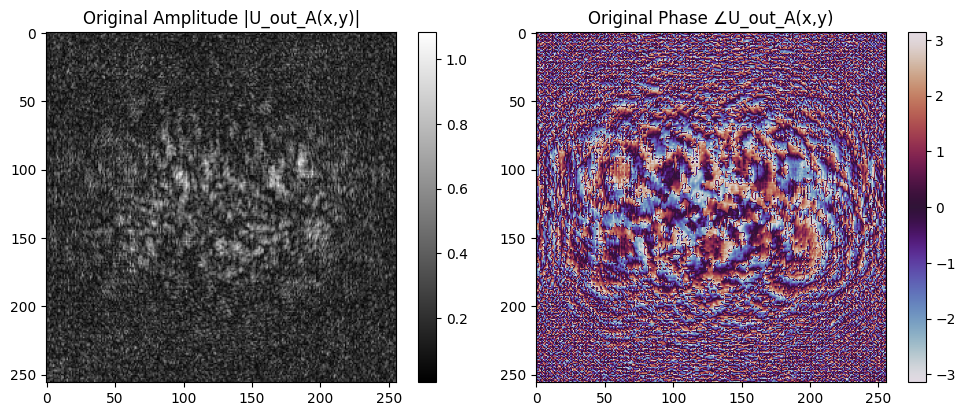

In [22]:
amplitude_orig = torch.abs(U_out_A).cpu().numpy()
phase_orig = torch.angle(U_out_A).cpu().numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Amplitude |U_out_A(x,y)|")
plt.imshow(amplitude_orig, cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Original Phase ∠U_out_A(x,y)")
plt.imshow(phase_orig, cmap="twilight")
plt.colorbar()

plt.tight_layout()
plt.show()


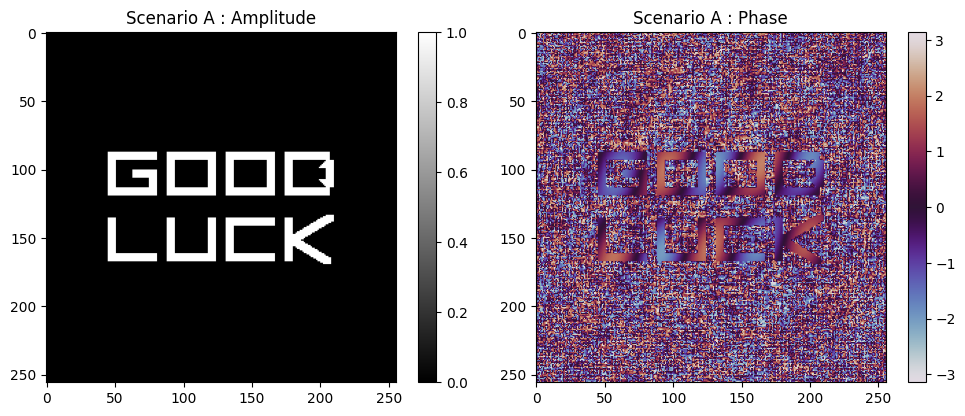

In [23]:
U_P2_estimated = propagate_angular_spectrum(U_out_A, Lz_segment, lambda0_scalar, Lx_phys, Ly_phys, backward=True)
U_P2_corrected = U_P2_estimated / t_mid_A
f_estimated = propagate_angular_spectrum(U_P2_corrected, Lz_segment, lambda0_scalar, Lx_phys, Ly_phys, backward=True)


amplitude = torch.abs(f_estimated).cpu().numpy()
phase = torch.angle(f_estimated).cpu().numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Scenario A : Amplitude")
plt.imshow(amplitude, cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Scenario A : Phase")
plt.imshow(phase, cmap="twilight")
plt.colorbar()

plt.tight_layout()
plt.show()


Since the middle transparency is phase only, the amplitude is not modified. It means that the system from P1 to P3 is linear and invertible, so we can use direct methods. In this case we used a time reversal approach by simply backpropagating through the system

## Scenario B

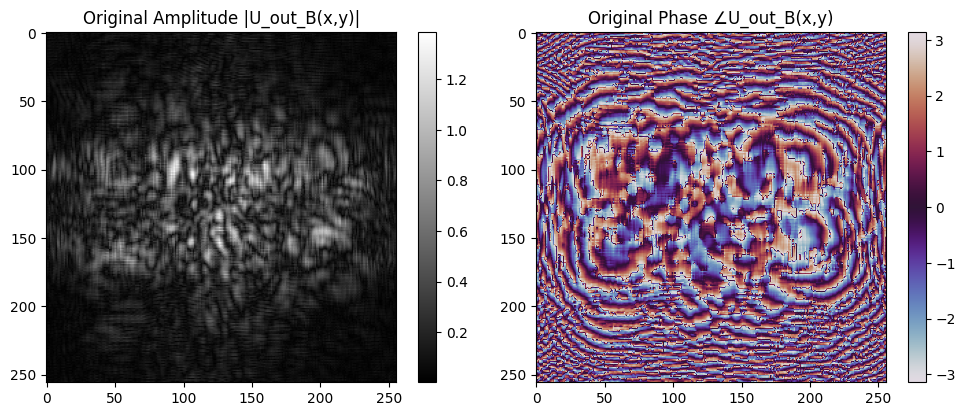

In [24]:
amplitude_orig = torch.abs(U_out_B).cpu().numpy()
phase_orig = torch.angle(U_out_B).cpu().numpy()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Amplitude |U_out_B(x,y)|")
plt.imshow(amplitude_orig, cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Original Phase ∠U_out_B(x,y)")
plt.imshow(phase_orig, cmap="twilight")
plt.colorbar()

plt.tight_layout()
plt.show()


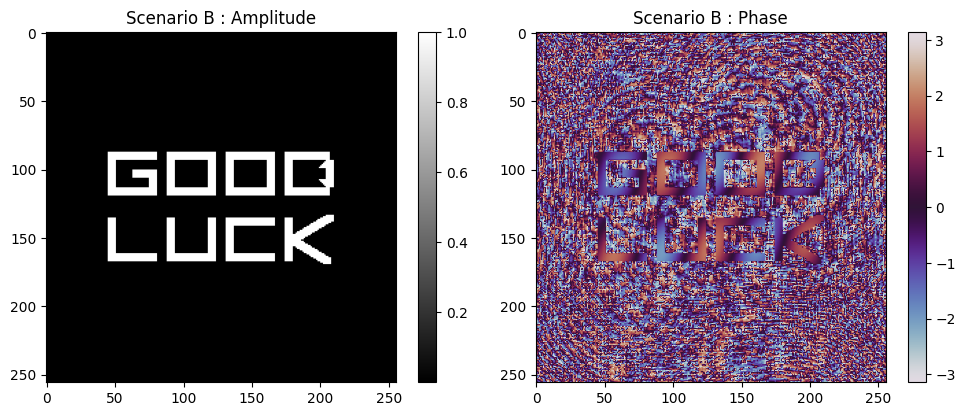

In [25]:
# th input field is the estimated field from Scenario A
field = f_estimated.clone().detach()

# Forward and backward operators as defined before
def forward_model(field):
    field = propagate_angular_spectrum(field, Lz_segment, lambda0_scalar, Lx_phys, Ly_phys)
    field = field * t_mid_B
    field = propagate_angular_spectrum(field, Lz_segment, lambda0_scalar, Lx_phys, Ly_phys)
    return field

def backward_model(field):
    field = propagate_angular_spectrum(field, Lz_segment, lambda0_scalar, Lx_phys, Ly_phys, backward=True)
    field = field / t_mid_B
    field = propagate_angular_spectrum(field, Lz_segment, lambda0_scalar, Lx_phys, Ly_phys, backward=True)
    return field

# GS with initialization
target_amp = torch.abs(U_out_B)
N = 200

for i in range(N):
    field = torch.abs(field) * torch.exp(1j * torch.angle(field))  # Keep current amplitude
    field_ft = forward_model(field)
    field_ft = target_amp * torch.exp(1j * torch.angle(field_ft))  # Replace amplitude at output
    field = backward_model(field_ft)

# Final result
f_est_B = field
amp_B = torch.abs(f_est_B).cpu().numpy()
phase_B = torch.angle(f_est_B).cpu().numpy()

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Scenario B : Amplitude")
plt.imshow(amp_B, cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Scenario B : Phase")
plt.imshow(phase_B, cmap="twilight")
plt.colorbar()
plt.tight_layout()
plt.show()


Since the input field f(x,y) is the same, we can it from A as the initial guess for a GS algorithm.
The amplitude seems to be exactly the same, but the phase is different, due to the iterative nature of the algo and the different middle transparency: both amplitude and phase changing.